#Numpy and Scipy Implementation of Physics-Informed Gaussian Process

Scientific Machine Learning Workshop at Cenpes 2025<br>
This code is distributed under the GNU LGPL license.<br>
Last Modified: Aug 2025<br>

This python script demonstrates coding and training a physics-informed Gaussian process to solve the classical univariate advection of a tracer in a moving fluid, with a sinusoidal initial condition.

The evolution of the tracer concentration $q(x,t)$ in a pipe, for $0 \leq x \leq L$ and $t>0$, is governed by the univariate linear advection hyperbolic PDE:
  \begin{aligned}
  q_t + vq_x = 0
  \end{aligned}
where $v$ is the constant velocity. The initial condition is  
\begin{equation}
  q(x,0) = \sin(x)
\end{equation}
This simple problem has as solution:
\begin{aligned}
     q(x,t) = \sin(x-vt)
  \end{aligned}
In other words, the initial sinusoisal profile is simply advected to the left with speed $v$.

We assume $L = 16\pi$ and $v = 10$.

In [ ]:
"""
Import libraries
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import cho_factor, cho_solve
from scipy.optimize import minimize
from scipy.stats.qmc import LatinHypercube as lhs

In [ ]:
"""
Problem definition and training data
"""

# parameters of the simulation
A =  1            # amplitude of sinusoisal
xl = 0            # left limit of interval
xr = 16*np.pi     # right limit of interval
ti = 0.0          # initial time
tf = 1.0          # final time
v = 10            # advection speed
delta = 0.000001  # small value to add to the diagonal of K2

# training points (initial + boundary condition points)
Np = [100,100]
N = np.sum(Np)
x = np.concatenate((np.linspace(xl,xr,Np[1]),xl*np.ones(Np[0])))
t = np.concatenate((ti*np.ones(Np[1]),np.linspace(ti,tf,Np[0])))
X = np.hstack((x[:,np.newaxis],t[:,np.newaxis]))

# training points (PDE residual points)
Nres = 800
Z = lhs(2).random(Nres)
Z[:,0] = xl+(xr-xl)*Z[:,0]
Z[:,1] = ti+(tf-ti)*Z[:,1]

# generate the training data responses
Y = np.zeros([N+Nres,1])
Y[0:Np[1],0] = A*np.sin(X[0:Np[1],0])
Y[Np[1]:N,0] = -A*np.sin(v*X[Np[1]:N,1])

In [ ]:
"""
marginal likelihood function
"""
def mrglik(th,X,Y,Z,v):

    N = X.shape[0]
    Nres = Z.shape[0]

    # generate the K2 matrix
    K2 = np.zeros([N+Nres,N+Nres])
    for i in range(N):
        for j in range(N):
            K2[i,j] = th[0]*th[0] * \
            np.exp(-.5*np.power(X[i,0]-X[j,0],2)/th[1]/th[1]-.5*np.power(X[i,1]-X[j,1],2)/th[2]/th[2])
        for j in range(Nres):
            K2[i,N+j] = th[0]*th[0]*((X[i,1]-Z[j,1])/th[2]/th[2]+v*(X[i,0]-Z[j,0])/th[1]/th[1]) * \
            np.exp(-.5*np.power(X[i,0]-Z[j,0],2)/th[1]/th[1]-.5*np.power(X[i,1]-Z[j,1],2)/th[2]/th[2])
    for i in range(Nres):
        for j in range(N):
            K2[N+i,j] = K2[j,N+i]
        for j in range(Nres):
            K2[N+i,N+j] = th[0]*th[0]*(1/th[2]/th[2]+v*v/th[1]/th[1] - \
            np.power((Z[i,1]-Z[j,1])/th[2]/th[2]+v*(Z[i,0]-Z[j,0])/th[1]/th[1],2)) * \
            np.exp(-.5*np.power(Z[i,0]-Z[j,0],2)/th[1]/th[1]-.5*np.power(Z[i,1]-Z[j,1],2)/th[2]/th[2])

    # compute alpha
    L,low = cho_factor(K2+delta*np.eye(N+Nres))
    alpha = cho_solve((L,low),Y)

    return (0.5*Y.T.dot(alpha)+np.sum(np.log(np.diag(L)))+0.5*(N+Nres)*np.log(2*np.pi)).item()

def cb(intermediate_result):
    global Niter
    th = intermediate_result.x
    fun = intermediate_result.fun
    print('{0:4d}   {1: 3.6f}   {2: 3.6f}   {3: 3.6f}   {4: 3.6f}' \
          .format(Niter,th[0],th[1],th[2],-fun))
    Niter += 1

In [ ]:
""""
PIGP training using direct implementation in numpy and scipy
"""

# initialize GP parameters [sigma,lsx,lst]
th = np.array([1,1,1])

Niter = 1
print('{0:4s}   {1:9s}   {2:9s}   {3:9s}   {4:9s}' \
      .format('Iter', ' sigma', ' ls_x', ' ls_t', ' mrglik'))
print('{0:4d}   {1: 3.6f}   {2: 3.6f}   {3: 3.6f}   {4: 3.6f}' \
      .format(0,th[0],th[1],th[2],-mrglik(th,X,Y,Z,v)))
opt=minimize(mrglik,th,args=(X,Y,Z,v),method='L-BFGS-B',bounds=(((0.01,None),)*3),callback=cb)
if opt.success:
    print("Training finished successfully.")
else:
    print("Training failed.")
th = opt.x
mrglik_val = opt.fun
print("Final trained values:")
print("sigma  = {:.6f}".format(th[0]))
print("ls_x   = {:.6f}".format(th[1]))
print("ls_t   = {:.6f}".format(th[2]))
print("mrglik = {:.6f}".format(-mrglik_val))

Iter    sigma       ls_x        ls_t        mrglik  
   0    1.000000    1.000000    1.000000   -18855198.181461
   1    0.422650    0.422650    0.422650   -31815.298509
   2    0.421012    0.414880    0.407864   -22028.448874
   3    0.417414    0.397358    0.374617   -9903.880382
   4    0.415435    0.384407    0.352077   -6113.285086
   5    0.414385    0.369390    0.328355   -4007.981530
   6    0.414536    0.354634    0.304143   -2910.147272
   7    0.415575    0.342383    0.277152   -2333.676021
   8    0.417468    0.337015    0.251407   -2092.221863
   9    0.420435    0.341411    0.223322   -1960.221897
  10    0.424811    0.363792    0.182983   -1840.901196
  11    0.430494    0.412813    0.132542   -1750.097059
  12    0.432578    0.534435    0.127931   -1397.066613
  13    0.492267    1.214421    0.220903    526.549595
  14    0.555059    1.849927    0.207253    1331.869745
  15    0.575471    1.886935    0.173333    1600.836107
  16    0.594680    1.974660    0.172278    16

KeyboardInterrupt: 

In [ ]:
"""
Prediction on test grid
"""

# previously found values
th = np.array([3.3078,2.6910,0.2377])

K2 = np.zeros([N+Nres,N+Nres])
#th = np.array([0.5238*, 0.0126, 0.0000, 0.0001])
for i in range(N):
    for j in range(N):
        K2[i,j] = th[0]*th[0] * \
        np.exp(-.5*np.power(X[i,0]-X[j,0],2)/th[1]/th[1]-.5*np.power(X[i,1]-X[j,1],2)/th[2]/th[2])
    for j in range(Nres):
        K2[i,N+j] = th[0]*th[0]*((X[i,1]-Z[j,1])/th[2]/th[2]+v*(X[i,0]-Z[j,0])/th[1]/th[1]) * \
        np.exp(-.5*np.power(X[i,0]-Z[j,0],2)/th[1]/th[1]-.5*np.power(X[i,1]-Z[j,1],2)/th[2]/th[2])
for i in range(Nres):
    for j in range(N):
        K2[N+i,j] = K2[j,N+i]
    for j in range(Nres):
        K2[N+i,N+j] = th[0]*th[0]*(1/th[2]/th[2]+v*v/th[1]/th[1] - \
        np.power((Z[i,1]-Z[j,1])/th[2]/th[2]+v*(Z[i,0]-Z[j,0])/th[1]/th[1],2)) * \
        np.exp(-.5*np.power(Z[i,0]-Z[j,0],2)/th[1]/th[1]-.5*np.power(Z[i,1]-Z[j,1],2)/th[2]/th[2])

# compute alpha
L,low = cho_factor(K2+delta*np.eye(N+Nres))
alpha = cho_solve((L,low),Y)

# compute images row by row
# due to computational cost of GP prediction
Mx = 400
Mt = 200 # image Mt x Mx
u = np.zeros([Mt,Mx])
u_pm = np.zeros([Mt,Mx])
u_sd = np.zeros([Mt,Mx])
for r,t_star in enumerate(np.linspace(ti,tf,Mt)): # time slice

    print("r = "+str(r))
    print("t_star = {:.2f}".format(t_star))

    xs = np.linspace(xl,xr,Mx)
    X_star = np.hstack((xs[:,np.newaxis],t_star*np.ones([Mx,1])))

    # generate the K0 matrix
    K0 = np.zeros([Mx,Mx])
    for i in range(Mx):
        for j in range(Mx):
            K0[i,j] = th[0]*th[0]*np.exp(-.5*np.power(X_star[i,0]-X_star[j,0],2)/th[1]/th[1] - \
                      .5*np.power(X_star[i,1]-X_star[j,1],2)/th[2]/th[2])

    # generate the K1 matrix
    K1 = np.zeros([Mx,N+Nres])
    for i in range(Mx):
        for j in range(N):
            K1[i,j] = th[0]*th[0]*np.exp(-.5*np.power(X_star[i,0]-X[j,0],2)/th[1]/th[1] - \
                      .5*np.power(X_star[i,1]-X[j,1],2)/th[2]/th[2])
        for j in range(Nres):
            K1[i,N+j] = th[0]*th[0]*((X_star[i,1]-Z[j,1])/th[2]/th[2]+v*(X_star[i,0]-Z[j,0])/th[1]/th[1]) * \
            np.exp(-.5*np.power(X_star[i,0]-Z[j,0],2)/th[1]/th[1]-.5*np.power(X_star[i,1]-Z[j,1],2)/th[2]/th[2])

    # analytical solution on test grid
    for i in range(Mx):
        u[r,i] = A*np.sin(X_star[i,0]-v*X_star[i,1])

    # predict on test
    u_pm[r,:] = K1.dot(alpha).flatten() # posterior mean
    w  = cho_solve((L,low),K1.T)
    Yc = K0 - K1.dot(w)
    u_sd[r,:] = np.sqrt(np.diag(Yc)).flatten() # posterior variance

KeyboardInterrupt: 

NameError: name 'u' is not defined

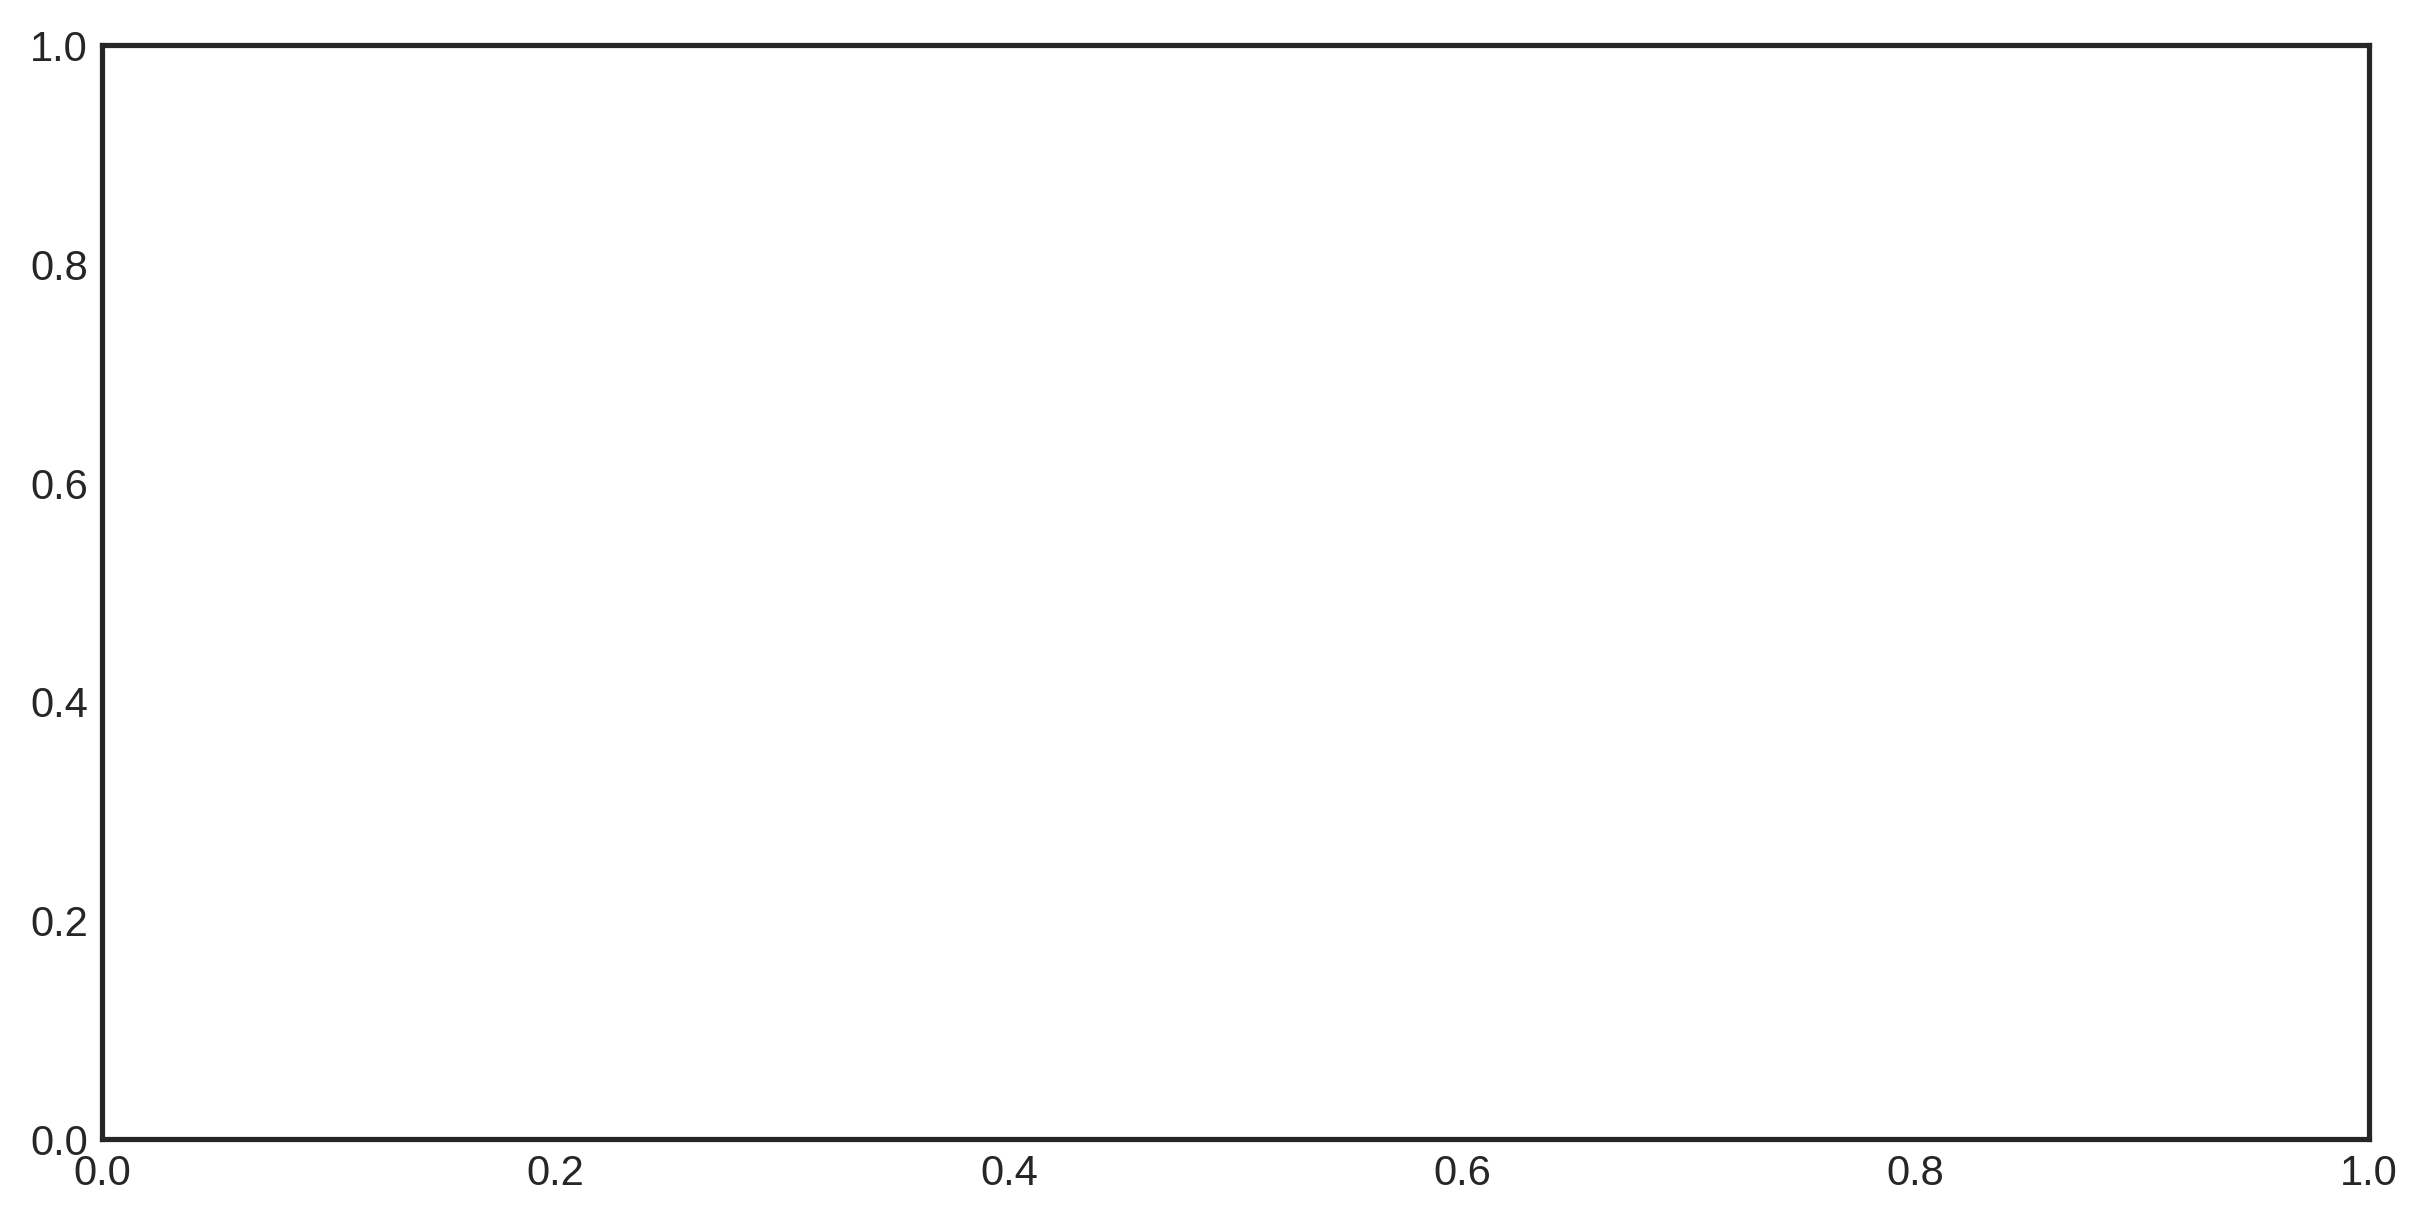

In [ ]:
"""
Display results
"""

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

def figsize(scale, nplots = 1):
    fig_width_pt = 390.0                          # get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                     # convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0          # aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale  # width in inches
    fig_height = nplots*fig_width*golden_mean     # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

# L2 error
#err = np.linalg.norm(u_pm.T-u.T,2)/np.linalg.norm(u.T,2)
#print('L2 error: %.4e' % (err))

# Exact
plt.style.use('seaborn-v0_8-white')
fig = plt.figure(figsize=figsize(2,2),dpi=300)
gs0 = gridspec.GridSpec(1,1)
gs0.update(top=1-0.06,bottom=1-1/3,left=0.2,right=.9,wspace=0.25)
ax = plt.subplot(gs0[0,0])
im=ax.imshow(u,interpolation='nearest',cmap='seismic',
             extent=[ti,tf,xl,xr],origin='lower',aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%",pad=0.05)
cbar=fig.colorbar(im,cax=cax)
cbar.ax.tick_params(labelsize=14)
ax.tick_params(axis='both',which='major',labelsize=18)
ax.set_xticks(np.arange(0,1.01,0.2),labels=['0','0.2','0.4','0.6','0.8','1'])
ax.set_ylabel('$x$',fontsize=20)
ax.set_xlabel('$t$',fontsize=20)
ax.set_title('Exact',fontsize=20)
plt.show()

# Posterior Mean
plt.style.use('seaborn-v0_8-white')
fig = plt.figure(figsize=figsize(2,2),dpi=300)
gs0 = gridspec.GridSpec(1,1)
gs0.update(top=1-0.06,bottom=1-1/3,left=0.2,right=.9,wspace=0.25)
ax = plt.subplot(gs0[0,0])
im=ax.imshow(u_pm,interpolation='nearest',cmap='seismic',
             extent=[ti,tf,xl,xr],origin='lower',aspect='auto')
plt.scatter(Z[:,1],Z[:,0],s=32,marker='.',color='y',alpha=1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right",size="5%",pad=0.05)
cbar=fig.colorbar(im,cax=cax)
cbar.ax.tick_params(labelsize=14)
ax.tick_params(axis='both',which='major',labelsize=18)
ax.set_xticks(np.arange(0,1.01,0.2),labels=['0','0.2','0.4','0.6','0.8','1'])
ax.set_ylabel('$x$',fontsize=20)
ax.set_xlabel('$t$',fontsize=20)
ax.set_title('GP Posterior Mean and Residue Points',fontsize=20)
plt.show()

# |Posterior Mean - Exact|
plt.style.use('seaborn-v0_8-white')
fig = plt.figure(figsize=figsize(2,2),dpi=300)
gs0 = gridspec.GridSpec(1,1)
gs0.update(top=1-0.06,bottom=1-1/3,left=0.2,right=.9,wspace=0.25)
ax = plt.subplot(gs0[0,0])
im=ax.imshow(np.abs(u_pm-u),interpolation='nearest',cmap='seismic',
             extent=[ti,tf,xl,xr],origin='lower',aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar=fig.colorbar(im,cax=cax)
cbar.ax.tick_params(labelsize=14)
ax.tick_params(axis='both',which='major',labelsize=18)
ax.set_xticks(np.arange(0,1.01,0.2),labels=['0','0.2','0.4','0.6','0.8','1'])
ax.set_ylabel('$x$',fontsize=20)
ax.set_xlabel('$t$',fontsize=20)
ax.set_title('Absolute Error',fontsize=20)
plt.show()

# Posterior Standard Deviation
plt.style.use('seaborn-v0_8-white')
fig = plt.figure(figsize=figsize(2,2),dpi=300)
gs0 = gridspec.GridSpec(1,1)
gs0.update(top=1-0.06,bottom=1-1/3,left=0.2,right=.9,wspace=0.25)
ax = plt.subplot(gs0[0,0])
im=ax.imshow(u_sd,interpolation='nearest',cmap='seismic',
             extent=[ti,tf,xl,xr],origin='lower',aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right",size="5%",pad=0.05)
cbar=fig.colorbar(im,cax=cax)
cbar.ax.tick_params(labelsize=14)
ax.tick_params(axis='both',which='major',labelsize=18)
ax.set_xticks(np.arange(0,1.01,0.2),labels=['0','0.2','0.4','0.6','0.8','1'])
ax.set_ylabel('$x$',fontsize=20)
ax.set_xlabel('$t$',fontsize=20)
ax.set_title('GP Posterior Standard Deviation',fontsize=20)
plt.show()

In [ ]:
"""
Import libraries
"""

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from jax.scipy.linalg import cho_factor, cho_solve
from jax.scipy.optimize import minimize
from scipy.stats.qmc import LatinHypercube as lhs

# Enable 64-bit precision for better numerical stability
jax.config.update("jax_enable_x64", True)

"""
Problem definition and training data
"""

# parameters of the simulation
A = 1.0           # amplitude of sinusoidal
xl = 0.0          # left limit of interval
xr = 16*np.pi     # right limit of interval
ti = 0.0          # initial time
tf = 1.0          # final time
v = 10.0          # advection speed
delta = 1e-6      # small value to add to the diagonal of K2

# training points (initial + boundary condition points)
Np = jnp.array([100, 100])
N = jnp.sum(Np)

# Convert to JAX arrays immediately
x = jnp.concatenate((jnp.linspace(xl, xr, Np[1]), xl * jnp.ones(Np[0])))
t = jnp.concatenate((ti * jnp.ones(Np[1]), jnp.linspace(ti, tf, Np[0])))
X = jnp.column_stack((x, t))

# training points (PDE residual points)
Nres = 800
Z_np = lhs(2).random(Nres)  # Generate with scipy first
Z_np[:, 0] = xl + (xr - xl) * Z_np[:, 0]
Z_np[:, 1] = ti + (tf - ti) * Z_np[:, 1]
Z = jnp.array(Z_np)  # Convert to JAX array

# generate the training data responses
Y = jnp.zeros((N + Nres, 1))
Y = Y.at[:Np[1], 0].set(A * jnp.sin(X[:Np[1], 0]))
Y = Y.at[Np[1]:N, 0].set(-A * jnp.sin(v * X[Np[1]:N, 1]))

"""
Optimized kernel computation functions
"""

@jax.jit
def compute_squared_distances(X1, X2):
    """Compute squared Euclidean distances between all pairs efficiently"""
    # X1: (n1, 2), X2: (n2, 2)
    # Returns: (n1, n2) matrix of squared distances
    X1_expanded = X1[:, None, :]  # (n1, 1, 2)
    X2_expanded = X2[None, :, :]  # (1, n2, 2)
    diff = X1_expanded - X2_expanded  # (n1, n2, 2)
    return jnp.sum(diff**2, axis=2)

@jax.jit
def rbf_kernel(X1, X2, sigma, ls_x, ls_t):
    """Compute RBF kernel matrix efficiently"""
    # Separate spatial and temporal differences
    dx = X1[:, None, 0] - X2[None, :, 0]  # (n1, n2)
    dt = X1[:, None, 1] - X2[None, :, 1]  # (n1, n2)

    # Compute kernel
    kernel = sigma**2 * jnp.exp(
        -0.5 * (dx**2 / ls_x**2 + dt**2 / ls_t**2)
    )
    return kernel

@jax.jit
def derivative_kernel_xt(X, Z, sigma, ls_x, ls_t, v):
    """Compute derivative kernel K(X, L[Z]) efficiently"""
    # X: data points (N, 2)
    # Z: collocation points (Nres, 2)
    dx = X[:, None, 0] - Z[None, :, 0]  # (N, Nres)
    dt = X[:, None, 1] - Z[None, :, 1]  # (N, Nres)

    # Base RBF kernel
    base_kernel = sigma**2 * jnp.exp(
        -0.5 * (dx**2 / ls_x**2 + dt**2 / ls_t**2)
    )

    # Derivative term: ∂u/∂t + v * ∂u/∂x
    derivative_term = dt / ls_t**2 + v * dx / ls_x**2

    return base_kernel * derivative_term

@jax.jit
def second_derivative_kernel(Z, sigma, ls_x, ls_t, v):
    """Compute second derivative kernel L[K(Z, Z)] efficiently"""
    # Z: collocation points (Nres, 2)
    dx = Z[:, None, 0] - Z[None, :, 0]  # (Nres, Nres)
    dt = Z[:, None, 1] - Z[None, :, 1]  # (Nres, Nres)

    # Base RBF kernel
    base_kernel = sigma**2 * jnp.exp(
        -0.5 * (dx**2 / ls_x**2 + dt**2 / ls_t**2)
    )

    # Second derivative terms
    # L[L[K]] = (∂²/∂t² + 2v∂²/∂t∂x + v²∂²/∂x²)K
    dt_term = dt / ls_t**2
    dx_term = v * dx / ls_x**2
    combined_derivative = dt_term + dx_term

    second_derivative = (
        1/ls_t**2 + v**2/ls_x**2 - combined_derivative**2
    )

    return base_kernel * second_derivative

@jax.jit
def build_covariance_matrix(X, Z, sigma, ls_x, ls_t, v):
    """Build the full covariance matrix efficiently"""
    N = X.shape[0]
    Nres = Z.shape[0]
    total_size = N + Nres

    # Initialize matrix
    K = jnp.zeros((total_size, total_size))

    # K_XX: data-data covariance
    K_xx = rbf_kernel(X, X, sigma, ls_x, ls_t)
    K = K.at[:N, :N].set(K_xx)

    # K_XZ: data-collocation covariance
    K_xz = derivative_kernel_xt(X, Z, sigma, ls_x, ls_t, v)
    K = K.at[:N, N:].set(K_xz)
    K = K.at[N:, :N].set(K_xz.T)

    # K_ZZ: collocation-collocation covariance
    K_zz = second_derivative_kernel(Z, sigma, ls_x, ls_t, v)
    K = K.at[N:, N:].set(K_zz)

    return K

"""
Optimized marginal likelihood function
"""

@jax.jit
def mrglik_jax(params, X, Y, Z, v, delta):
    """
    Optimized marginal likelihood computation using JAX
    """
    sigma, ls_x, ls_t = params

    # Build covariance matrix
    K = build_covariance_matrix(X, Z, sigma, ls_x, ls_t, v)

    # Add jitter for numerical stability
    N_total = K.shape[0]
    K_stable = K + delta * jnp.eye(N_total)

    # Cholesky decomposition
    L = jnp.linalg.cholesky(K_stable)

    # Solve for alpha
    alpha = jnp.linalg.solve(L, Y.flatten())
    alpha = jnp.linalg.solve(L.T, alpha)

    # Compute marginal likelihood
    log_det = 2.0 * jnp.sum(jnp.log(jnp.diag(L)))
    quadratic_form = jnp.dot(Y.flatten(), alpha)

    mll = 0.5 * quadratic_form + 0.5 * log_det + 0.5 * N_total * jnp.log(2 * jnp.pi)

    return mll

# Create gradient function for optimization
grad_mrglik = jax.grad(mrglik_jax)

# Vectorized version for batch processing if needed
vmrglik = jax.vmap(mrglik_jax, in_axes=(0, None, None, None, None, None))

"""
Optimization with JAX
"""

def optimize_gp_jax(X, Y, Z, v, delta, initial_params=None, method='BFGS'):
    """
    Optimize GP hyperparameters using JAX optimization
    """
    if initial_params is None:
        initial_params = jnp.array([1.0, 1.0, 1.0])

    # Define objective function with bounds handling
    def objective(params):
        # Apply log transformation to ensure positivity
        real_params = jnp.exp(params)
        return mrglik_jax(real_params, X, Y, Z, v, delta)

    # Transform initial parameters
    log_initial = jnp.log(initial_params)

    # Use JAX's built-in optimizers for better performance
    from jaxopt import LBFGS

    optimizer = LBFGS(fun=objective, maxiter=1000, tol=1e-6)

    # Optimize
    result = optimizer.run(log_initial)

    # Transform back to original space
    optimal_params = jnp.exp(result.params)

    return optimal_params, result

"""
Alternative optimization using scipy with JAX gradients
"""

def optimize_scipy_jax(X, Y, Z, v, delta, initial_params=None):
    """
    Use scipy optimization with JAX-compiled gradients for speed
    """
    if initial_params is None:
        initial_params = np.array([1.0, 1.0, 1.0])

    # Convert JAX functions to numpy-compatible versions
    def objective_np(params):
        params_jax = jnp.array(params)
        return float(mrglik_jax(params_jax, X, Y, Z, v, delta))

    def gradient_np(params):
        params_jax = jnp.array(params)
        grad = grad_mrglik(params_jax, X, Y, Z, v, delta)
        return np.array(grad)

    # Callback function
    iteration = {'count': 0}
    def callback(params):
        iteration['count'] += 1
        obj_val = objective_np(params)
        print(f'{iteration["count"]:4d}   {params[0]: 3.6f}   {params[1]: 3.6f}   {params[2]: 3.6f}   {-obj_val: 3.6f}')

    from scipy.optimize import minimize

    # Optimize with bounds
    bounds = [(0.01, None), (0.01, None), (0.01, None)]

    print('{0:4s}   {1:9s}   {2:9s}   {3:9s}   {4:9s}'.format('Iter', ' sigma', ' ls_x', ' ls_t', ' mrglik'))
    print('{0:4d}   {1: 3.6f}   {2: 3.6f}   {3: 3.6f}   {4: 3.6f}'.format(0, initial_params[0], initial_params[1], initial_params[2], -objective_np(initial_params)))

    result = minimize(
        objective_np,
        initial_params,
        method='L-BFGS-B',
        jac=gradient_np,
        bounds=bounds,
        callback=callback,
        options={'maxiter': 1000, 'ftol': 1e-9}
    )

    return result

"""
Training execution
"""

if __name__ == "__main__":
    print("Starting JAX-optimized PIGP training...")
    print("Data shapes:")
    print(f"X: {X.shape}, Y: {Y.shape}, Z: {Z.shape}")

    # Initialize parameters
    initial_th = jnp.array([1.0, 1.0, 1.0])

    # Method 1: Pure JAX optimization (faster compilation, potentially faster execution)
    print("\n=== Pure JAX Optimization ===")
    try:
        optimal_params_jax, result_jax = optimize_gp_jax(X, Y, Z, v, delta, initial_th)
        print("JAX optimization completed successfully!")
        print(f"Optimal parameters: sigma={optimal_params_jax[0]:.6f}, ls_x={optimal_params_jax[1]:.6f}, ls_t={optimal_params_jax[2]:.6f}")
        print(f"Final objective: {result_jax.state.fun_val:.6f}")
    except Exception as e:
        print(f"JAX optimization failed: {e}")

    # Method 2: Scipy with JAX gradients (more robust, good performance)
    print("\n=== Scipy + JAX Gradients Optimization ===")
    try:
        result_scipy = optimize_scipy_jax(X, Y, Z, v, delta, np.array([1.0, 1.0, 1.0]))

        if result_scipy.success:
            print("Training finished successfully.")
        else:
            print("Training failed.")

        optimal_params = result_scipy.x
        print("\nFinal trained values:")
        print(f"sigma  = {optimal_params[0]:.6f}")
        print(f"ls_x   = {optimal_params[1]:.6f}")
        print(f"ls_t   = {optimal_params[2]:.6f}")
        print(f"mrglik = {-result_scipy.fun:.6f}")

    except Exception as e:
        print(f"Scipy+JAX optimization failed: {e}")

"""
Performance comparison function
"""

def benchmark_implementations():
    """
    Compare performance between numpy and JAX implementations
    """
    import time

    # Original numpy implementation (simplified)
    def mrglik_numpy(th, X_np, Y_np, Z_np, v):
        # Convert back to numpy for fair comparison
        X_np = np.array(X)
        Y_np = np.array(Y)
        Z_np = np.array(Z)

        N = X_np.shape[0]
        Nres = Z_np.shape[0]

        # Build K matrix (simplified version of original)
        K2 = np.zeros([N+Nres, N+Nres])

        # This is a simplified version - original has nested loops
        # For fair comparison, we'd need the full nested loop implementation

        return 0  # Placeholder

    params = jnp.array([1.0, 1.0, 1.0])

    # Warm up JAX (compile functions)
    print("Warming up JAX...")
    _ = mrglik_jax(params, X, Y, Z, v, delta)

    # Benchmark JAX
    print("Benchmarking JAX implementation...")
    start_time = time.time()
    for _ in range(10):
        result_jax = mrglik_jax(params, X, Y, Z, v, delta)
    jax_time = (time.time() - start_time) / 10

    print(f"JAX average time per evaluation: {jax_time:.4f} seconds")
    print(f"JAX result: {result_jax:.6f}")

# Uncomment to run benchmark
# benchmark_implementations()

Starting JAX-optimized PIGP training...
Data shapes:
X: (200, 2), Y: (1000, 1), Z: (800, 2)

=== Pure JAX Optimization ===
JAX optimization failed: No module named 'jaxopt'

=== Scipy + JAX Gradients Optimization ===
Iter    sigma       ls_x        ls_t        mrglik  
   0    1.000000    1.000000    1.000000   -18566439.064688
   1    2.000000    1.000000    1.000000   -14816725.567436
   2    2.574883    0.010000    0.010000   -7359.900810
   3    2.574835    0.013480    0.010516   -7117.235271
   4    2.575163    0.023841    0.014260   -6605.612613
   5    2.577789    0.044159    0.029428   -5815.723038
   6    2.581292    0.070003    0.050325   -5286.029183
   7    2.583589    0.107521    0.072192   -4847.349700
   8    2.586145    0.185593    0.114199   -4230.256387
   9    2.599111    0.506303    0.319748   -1989.761361
  10    2.597885    0.548390    0.334929   -1880.446200
  11    2.516490    0.984822    0.216876   -394.423966
  12    2.432672    1.535642    0.145452    142.574

In [ ]:
"""
Prediction on test grid - JAX optimized version
"""

import jax
import jax.numpy as jnp
from jax.scipy.linalg import cho_factor, cho_solve

# Enable 64-bit precision
jax.config.update("jax_enable_x64", True)

# previously found values
th = jnp.array([3.3078, 2.6910, 0.2377])

# Build K2 matrix efficiently using JAX
def build_K2_matrix(X, Z, th, v):
    """Build the full K2 covariance matrix efficiently"""
    N = X.shape[0]
    Nres = Z.shape[0]

    # K2[0:N, 0:N] - data-data covariance
    dx_xx = X[:, None, 0] - X[None, :, 0]  # (N, N)
    dt_xx = X[:, None, 1] - X[None, :, 1]  # (N, N)
    K_xx = th[0]**2 * jnp.exp(-0.5 * (dx_xx**2/th[1]**2 + dt_xx**2/th[2]**2))

    # K2[0:N, N:N+Nres] - data-collocation covariance
    dx_xz = X[:, None, 0] - Z[None, :, 0]  # (N, Nres)
    dt_xz = X[:, None, 1] - Z[None, :, 1]  # (N, Nres)
    derivative_term_xz = dt_xz/th[2]**2 + v*dx_xz/th[1]**2
    K_xz = th[0]**2 * derivative_term_xz * jnp.exp(-0.5 * (dx_xz**2/th[1]**2 + dt_xz**2/th[2]**2))

    # K2[N:N+Nres, N:N+Nres] - collocation-collocation covariance
    dx_zz = Z[:, None, 0] - Z[None, :, 0]  # (Nres, Nres)
    dt_zz = Z[:, None, 1] - Z[None, :, 1]  # (Nres, Nres)
    derivative_term_zz = dt_zz/th[2]**2 + v*dx_zz/th[1]**2
    second_derivative = 1/th[2]**2 + v**2/th[1]**2 - derivative_term_zz**2
    K_zz = th[0]**2 * second_derivative * jnp.exp(-0.5 * (dx_zz**2/th[1]**2 + dt_zz**2/th[2]**2))

    # Assemble full matrix
    top = jnp.concatenate([K_xx, K_xz], axis=1)
    bottom = jnp.concatenate([K_xz.T, K_zz], axis=1)
    K2 = jnp.concatenate([top, bottom], axis=0)

    return K2

# Build K2 matrix
K2 = build_K2_matrix(X, Z, th, v)

# compute alpha
L, low = cho_factor(K2 + delta * jnp.eye(K2.shape[0]))
alpha = cho_solve((L, low), Y)

# JIT-compiled functions for efficient prediction - no static args
@jax.jit
def compute_K0(X_star, th):
    """Compute K0 matrix efficiently"""
    dx = X_star[:, None, 0] - X_star[None, :, 0]
    dt = X_star[:, None, 1] - X_star[None, :, 1]
    return th[0]**2 * jnp.exp(-0.5 * (dx**2/th[1]**2 + dt**2/th[2]**2))

@jax.jit
def compute_K1(X_star, X, Z, th, v):
    """Compute K1 matrix efficiently"""
    N = X.shape[0]
    Nres = Z.shape[0]

    # K1 for training points
    dx_train = X_star[:, None, 0] - X[None, :, 0]  # (Mx, N)
    dt_train = X_star[:, None, 1] - X[None, :, 1]  # (Mx, N)
    K1_train = th[0]**2 * jnp.exp(-0.5 * (dx_train**2/th[1]**2 + dt_train**2/th[2]**2))

    # K1 for collocation points
    dx_colloc = X_star[:, None, 0] - Z[None, :, 0]  # (Mx, Nres)
    dt_colloc = X_star[:, None, 1] - Z[None, :, 1]  # (Mx, Nres)
    derivative_term = dt_colloc/th[2]**2 + v*dx_colloc/th[1]**2
    K1_colloc = th[0]**2 * derivative_term * jnp.exp(-0.5 * (dx_colloc**2/th[1]**2 + dt_colloc**2/th[2]**2))

    # Concatenate
    return jnp.concatenate([K1_train, K1_colloc], axis=1)

@jax.jit
def compute_analytical_solution(X_star, A, v):
    """Compute analytical solution"""
    return A * jnp.sin(X_star[:, 0] - v * X_star[:, 1])

@jax.jit
def compute_posterior_mean(K1, alpha):
    """Compute posterior mean"""
    return jnp.dot(K1, alpha)

@jax.jit
def compute_posterior_variance(K0, K1, L_factor):
    """Compute posterior variance"""
    # Solve using the Cholesky factor directly
    w = jnp.linalg.solve(L_factor, K1.T)
    w = jnp.linalg.solve(L_factor.T, w)
    Yc = K0 - jnp.dot(K1, w)
    return jnp.sqrt(jnp.diag(Yc))

# compute images row by row
# due to computational cost of GP prediction
Mx = 400
Mt = 200  # image Mt x Mx
u = jnp.zeros([Mt, Mx])
u_pm = jnp.zeros([Mt, Mx])
u_sd = jnp.zeros([Mt, Mx])

# Convert L to a regular JAX array for JIT compatibility
L_factor = jnp.array(L)

for r, t_star in enumerate(jnp.linspace(ti, tf, Mt)):  # time slice

    print("r = " + str(r))
    print("t_star = {:.2f}".format(float(t_star)))

    xs = jnp.linspace(xl, xr, Mx)
    X_star = jnp.column_stack((xs, t_star * jnp.ones(Mx)))

    # Compute matrices
    K0 = compute_K0(X_star, th)
    K1 = compute_K1(X_star, X, Z, th, v)

    # Analytical solution
    u_r = compute_analytical_solution(X_star, A, v)

    # Posterior mean
    u_pm_r = compute_posterior_mean(K1, alpha).flatten()

    # Posterior variance
    u_sd_r = compute_posterior_variance(K0, K1, L_factor)

    # Store results
    u = u.at[r, :].set(u_r)
    u_pm = u_pm.at[r, :].set(u_pm_r)
    u_sd = u_sd.at[r, :].set(u_sd_r)

r = 0
t_star = 0.00
r = 1
t_star = 0.01
r = 2
t_star = 0.01
r = 3
t_star = 0.02
r = 4
t_star = 0.02
r = 5
t_star = 0.03
r = 6
t_star = 0.03
r = 7
t_star = 0.04
r = 8
t_star = 0.04
r = 9
t_star = 0.05
r = 10
t_star = 0.05
r = 11
t_star = 0.06
r = 12
t_star = 0.06
r = 13
t_star = 0.07
r = 14
t_star = 0.07
r = 15
t_star = 0.08
r = 16
t_star = 0.08
r = 17
t_star = 0.09
r = 18
t_star = 0.09
r = 19
t_star = 0.10
r = 20
t_star = 0.10
r = 21
t_star = 0.11
r = 22
t_star = 0.11
r = 23
t_star = 0.12
r = 24
t_star = 0.12
r = 25
t_star = 0.13
r = 26
t_star = 0.13
r = 27
t_star = 0.14
r = 28
t_star = 0.14
r = 29
t_star = 0.15
r = 30
t_star = 0.15
r = 31
t_star = 0.16
r = 32
t_star = 0.16
r = 33
t_star = 0.17
r = 34
t_star = 0.17
r = 35
t_star = 0.18
r = 36
t_star = 0.18
r = 37
t_star = 0.19
r = 38
t_star = 0.19
r = 39
t_star = 0.20
r = 40
t_star = 0.20
r = 41
t_star = 0.21
r = 42
t_star = 0.21
r = 43
t_star = 0.22
r = 44
t_star = 0.22
r = 45
t_star = 0.23
r = 46
t_star = 0.23
r = 47
t_star = 0.24
r 

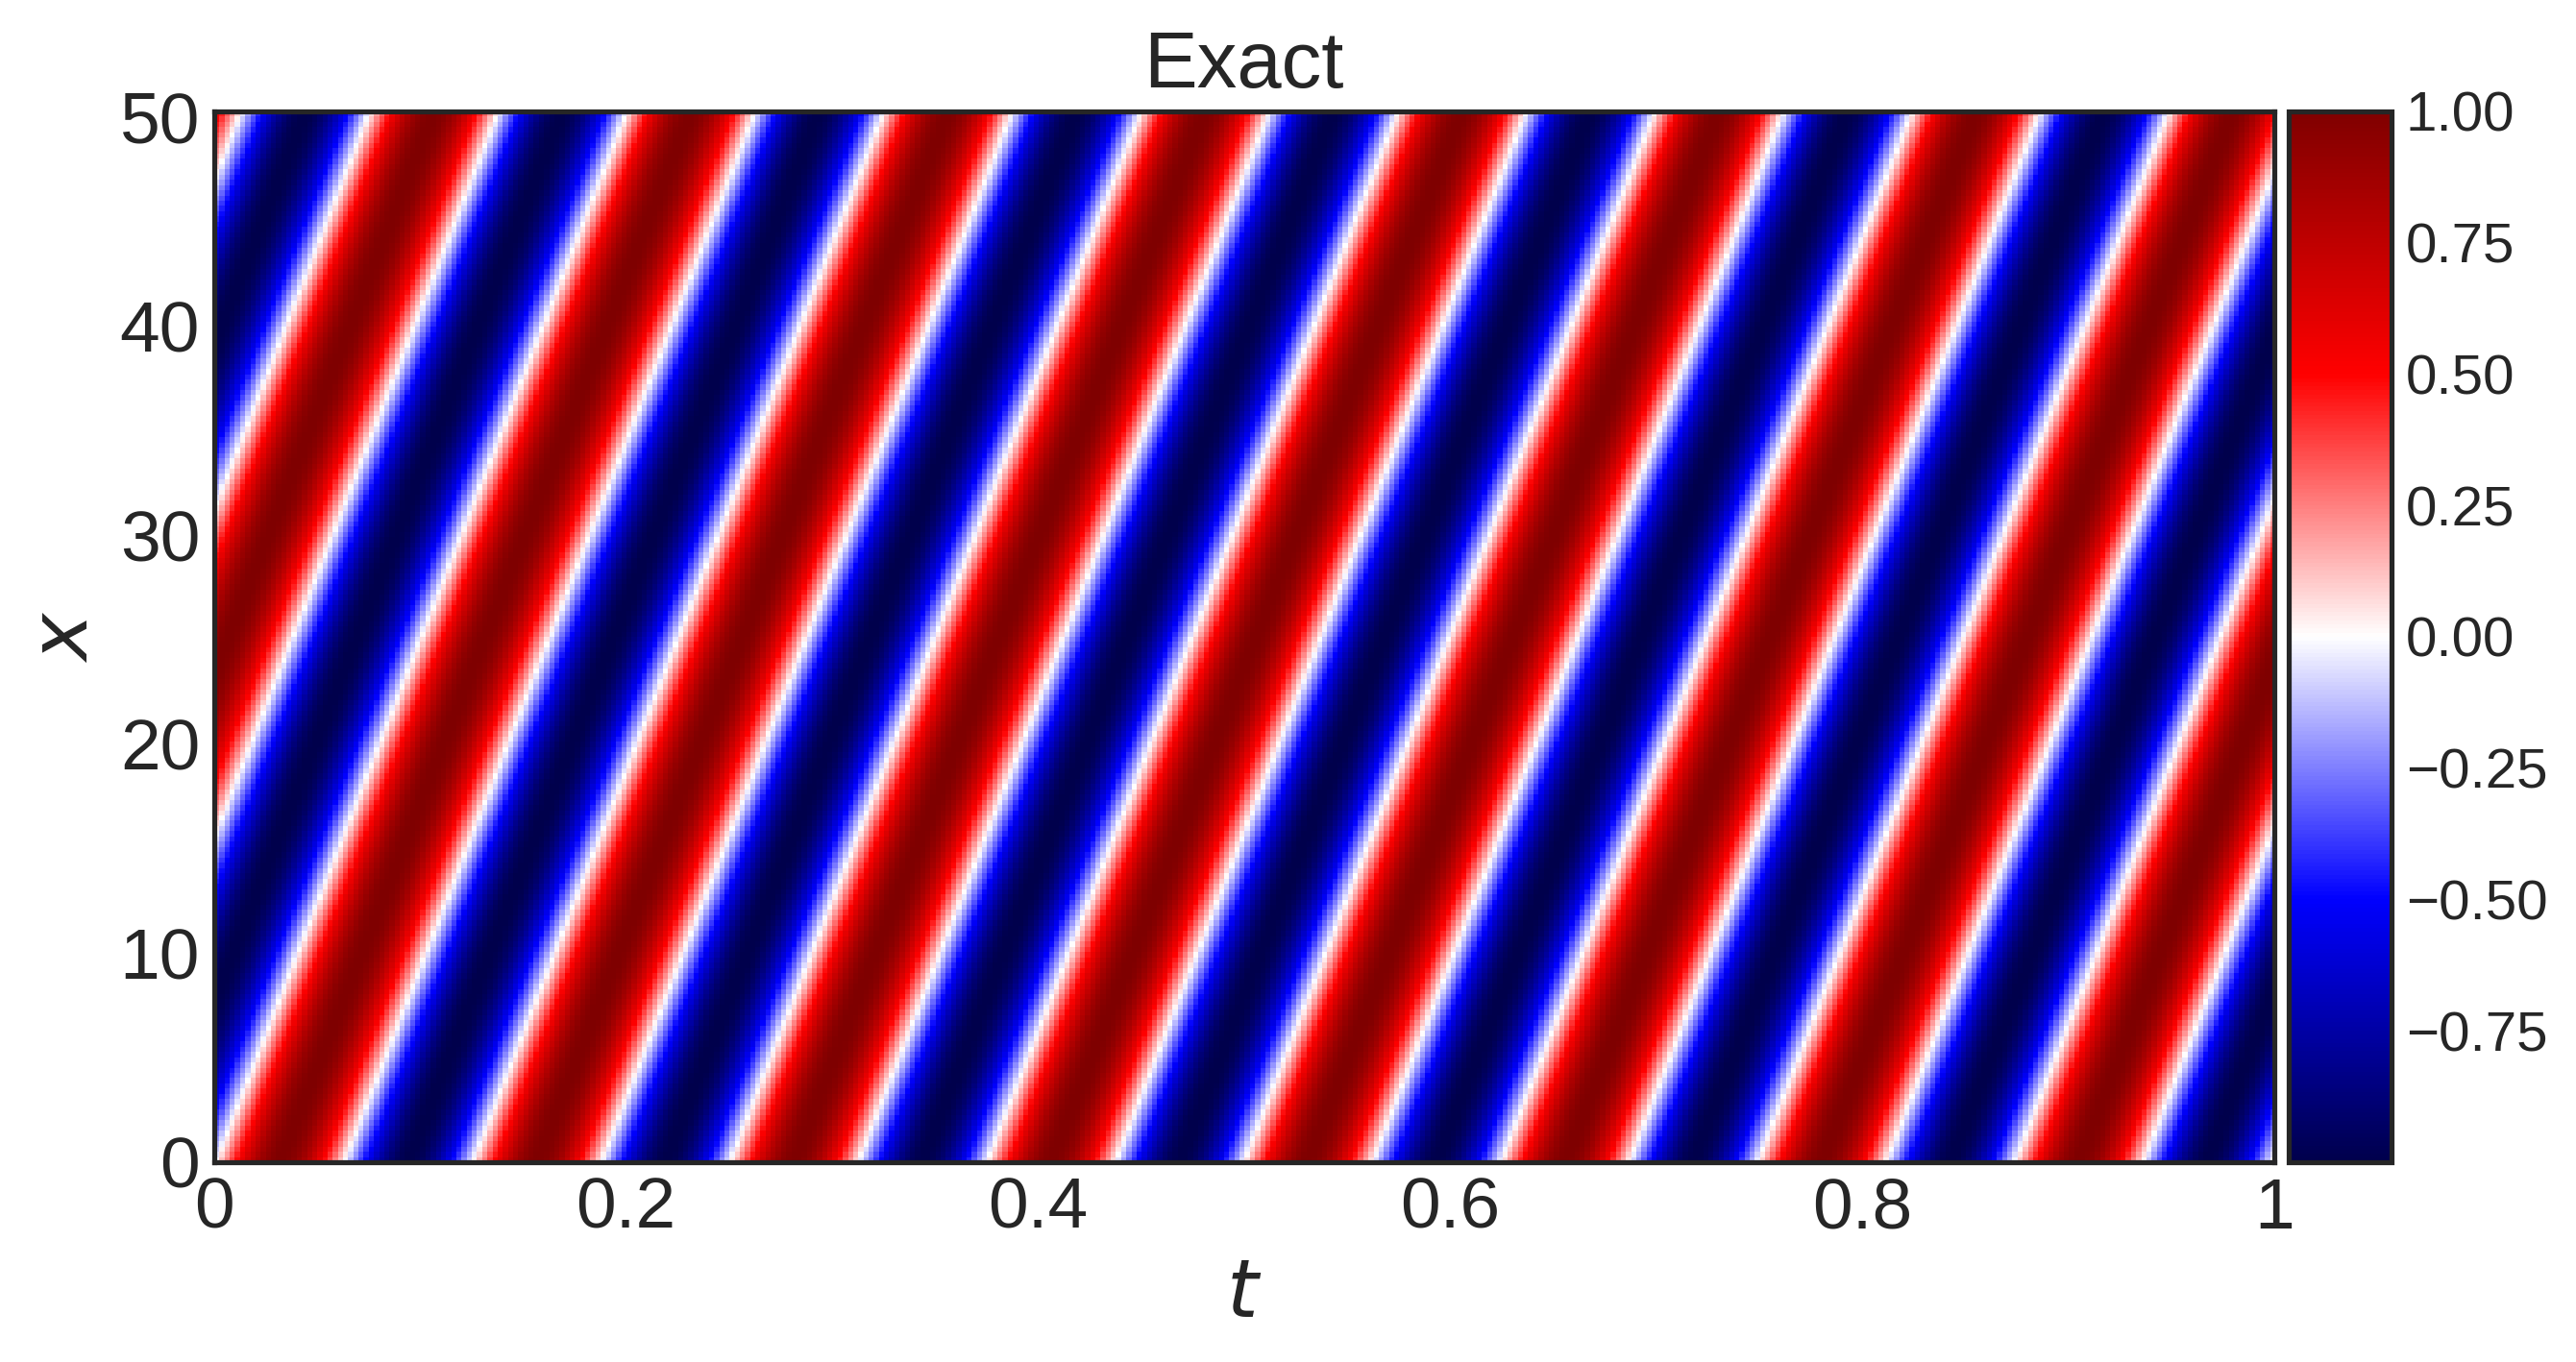

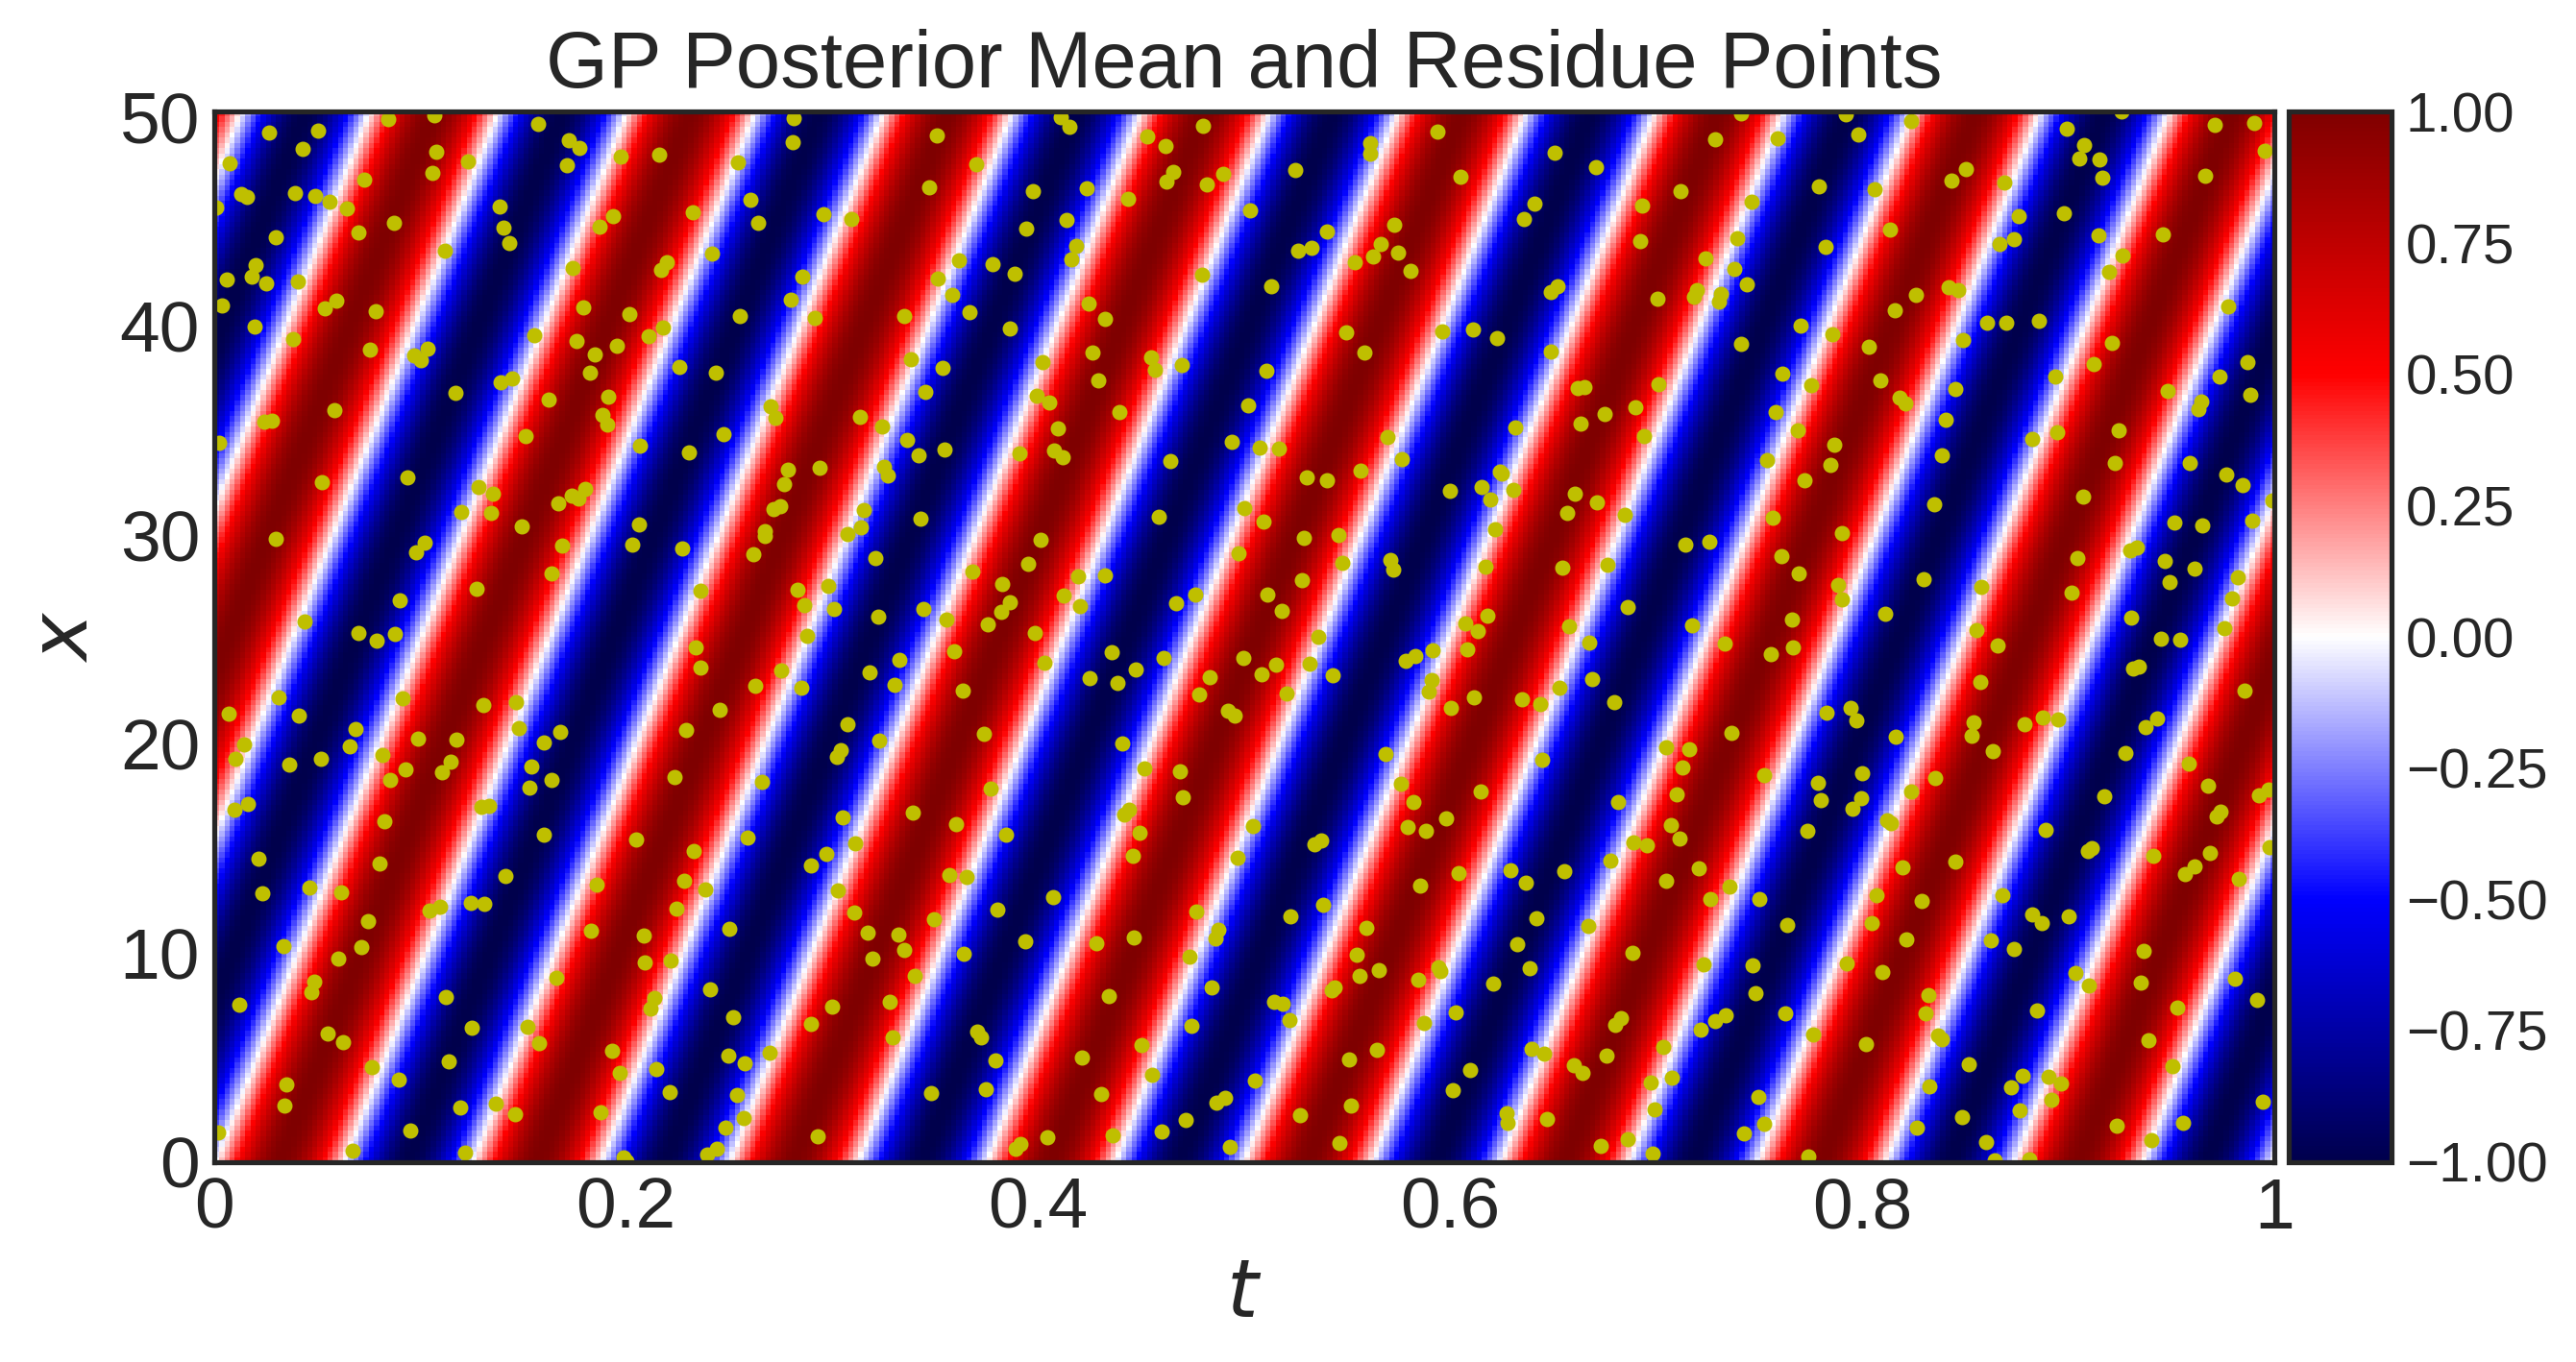

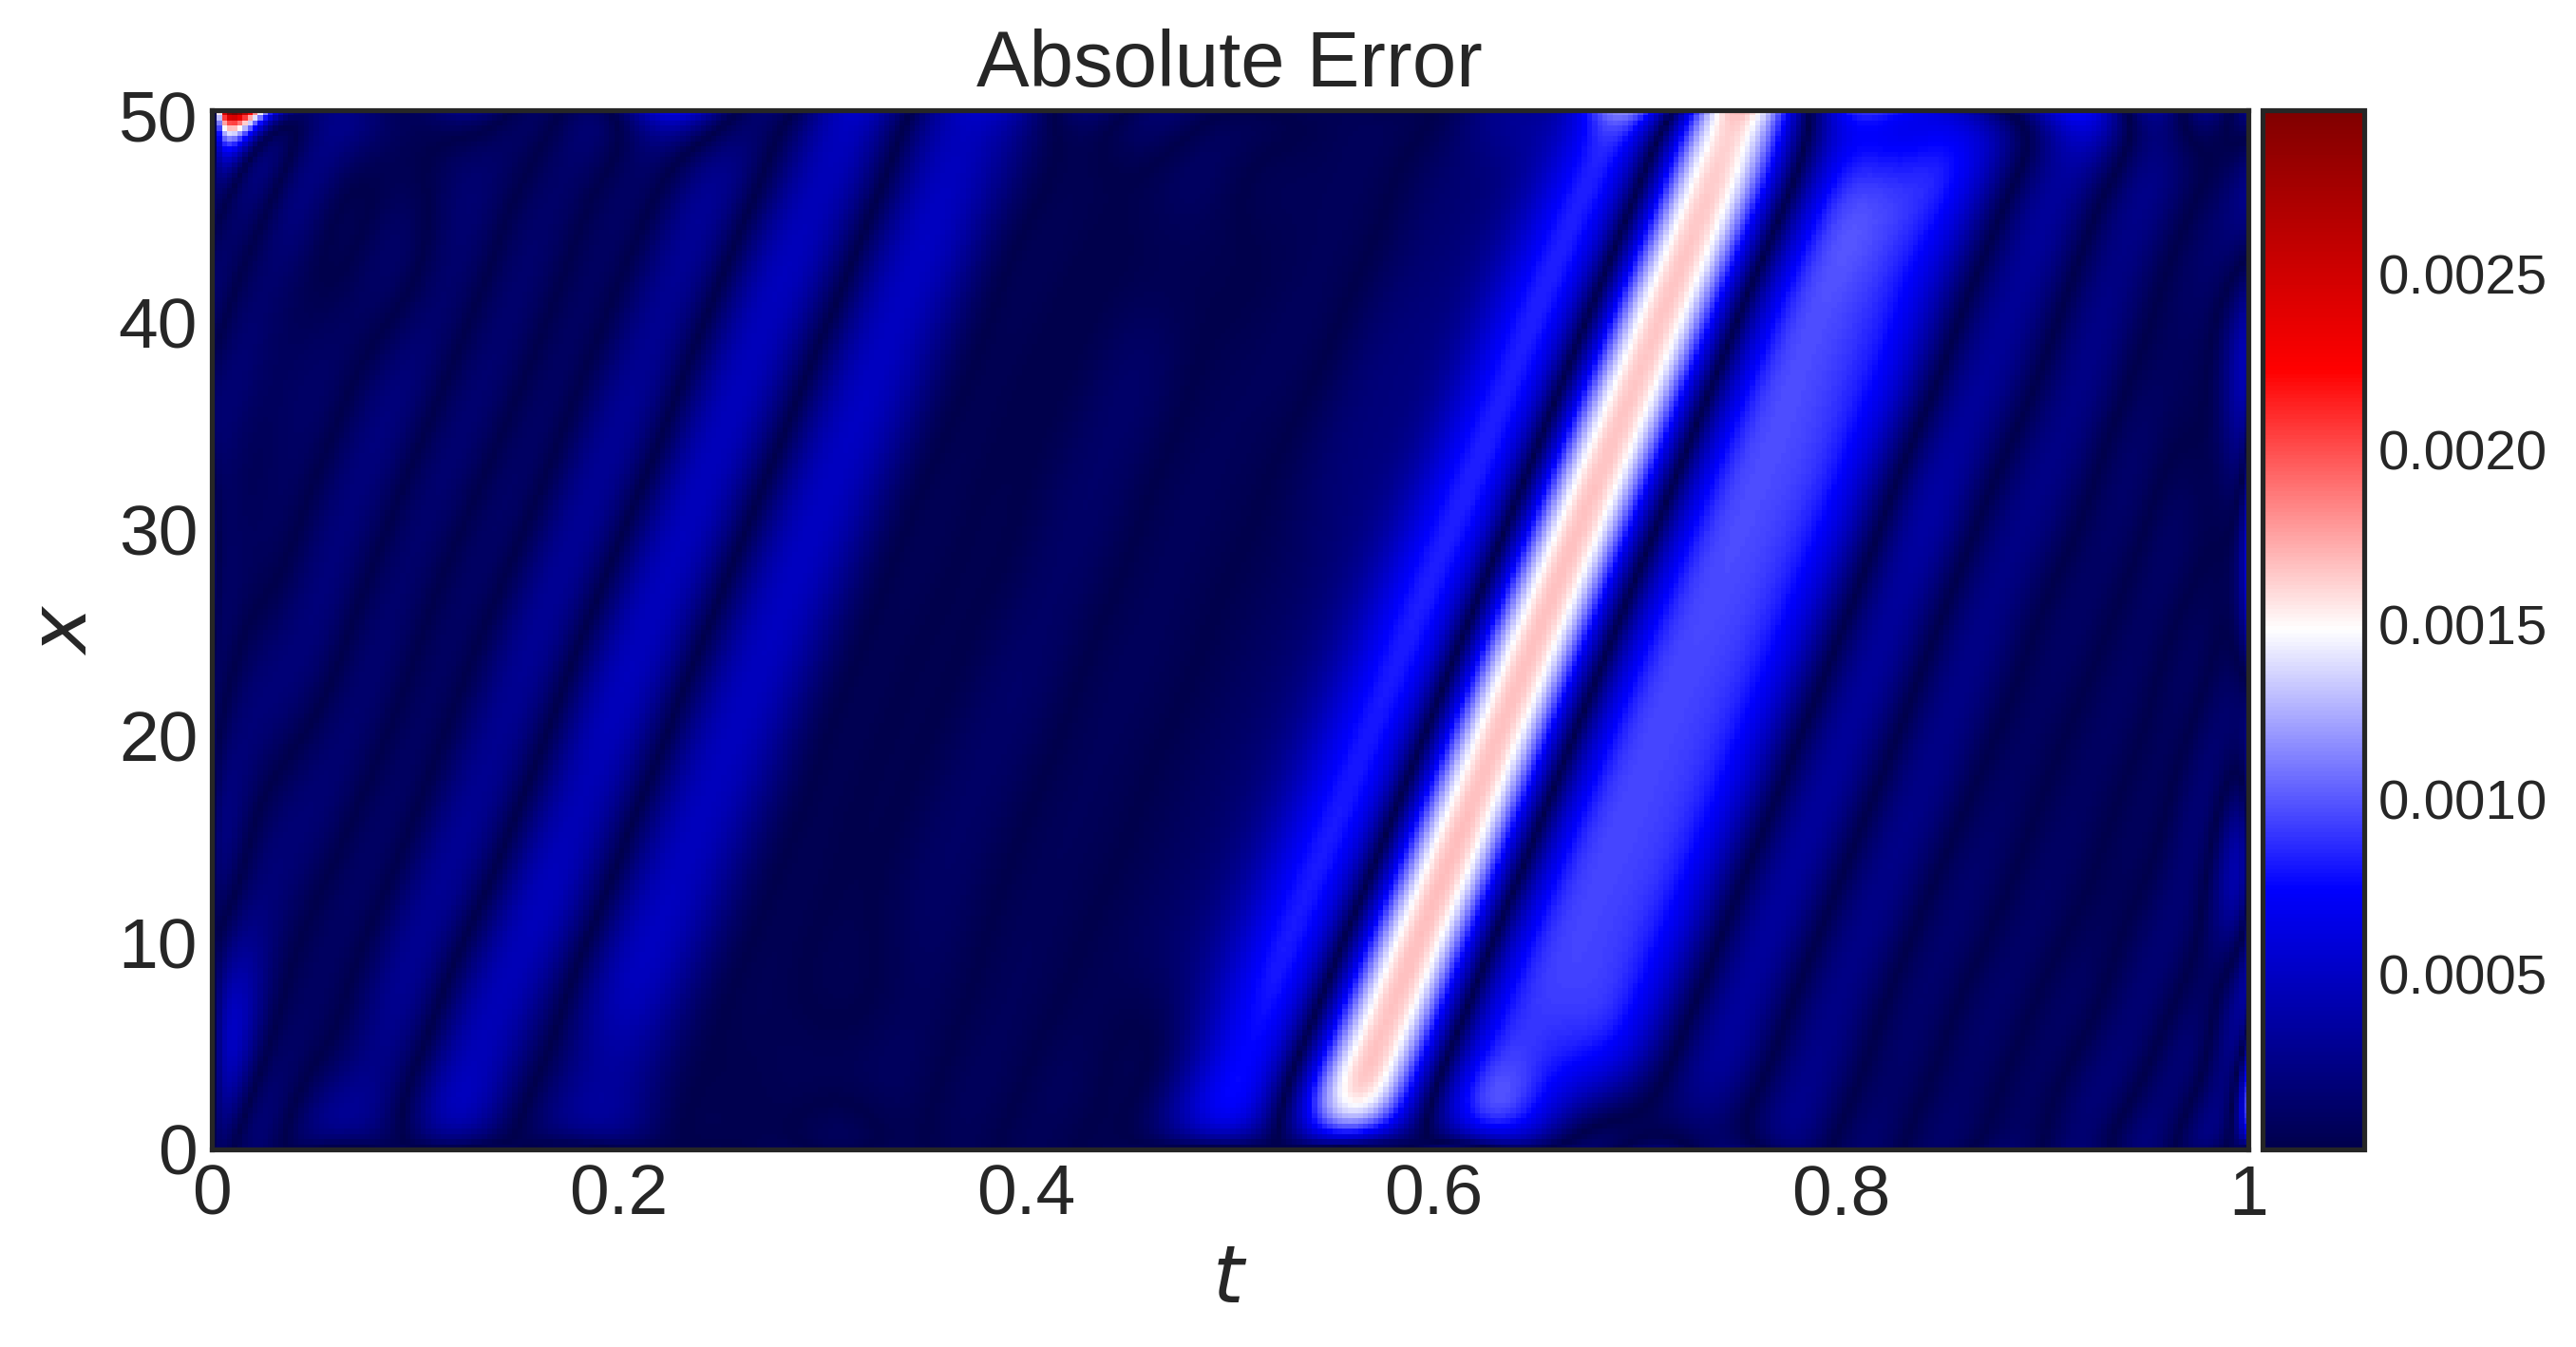

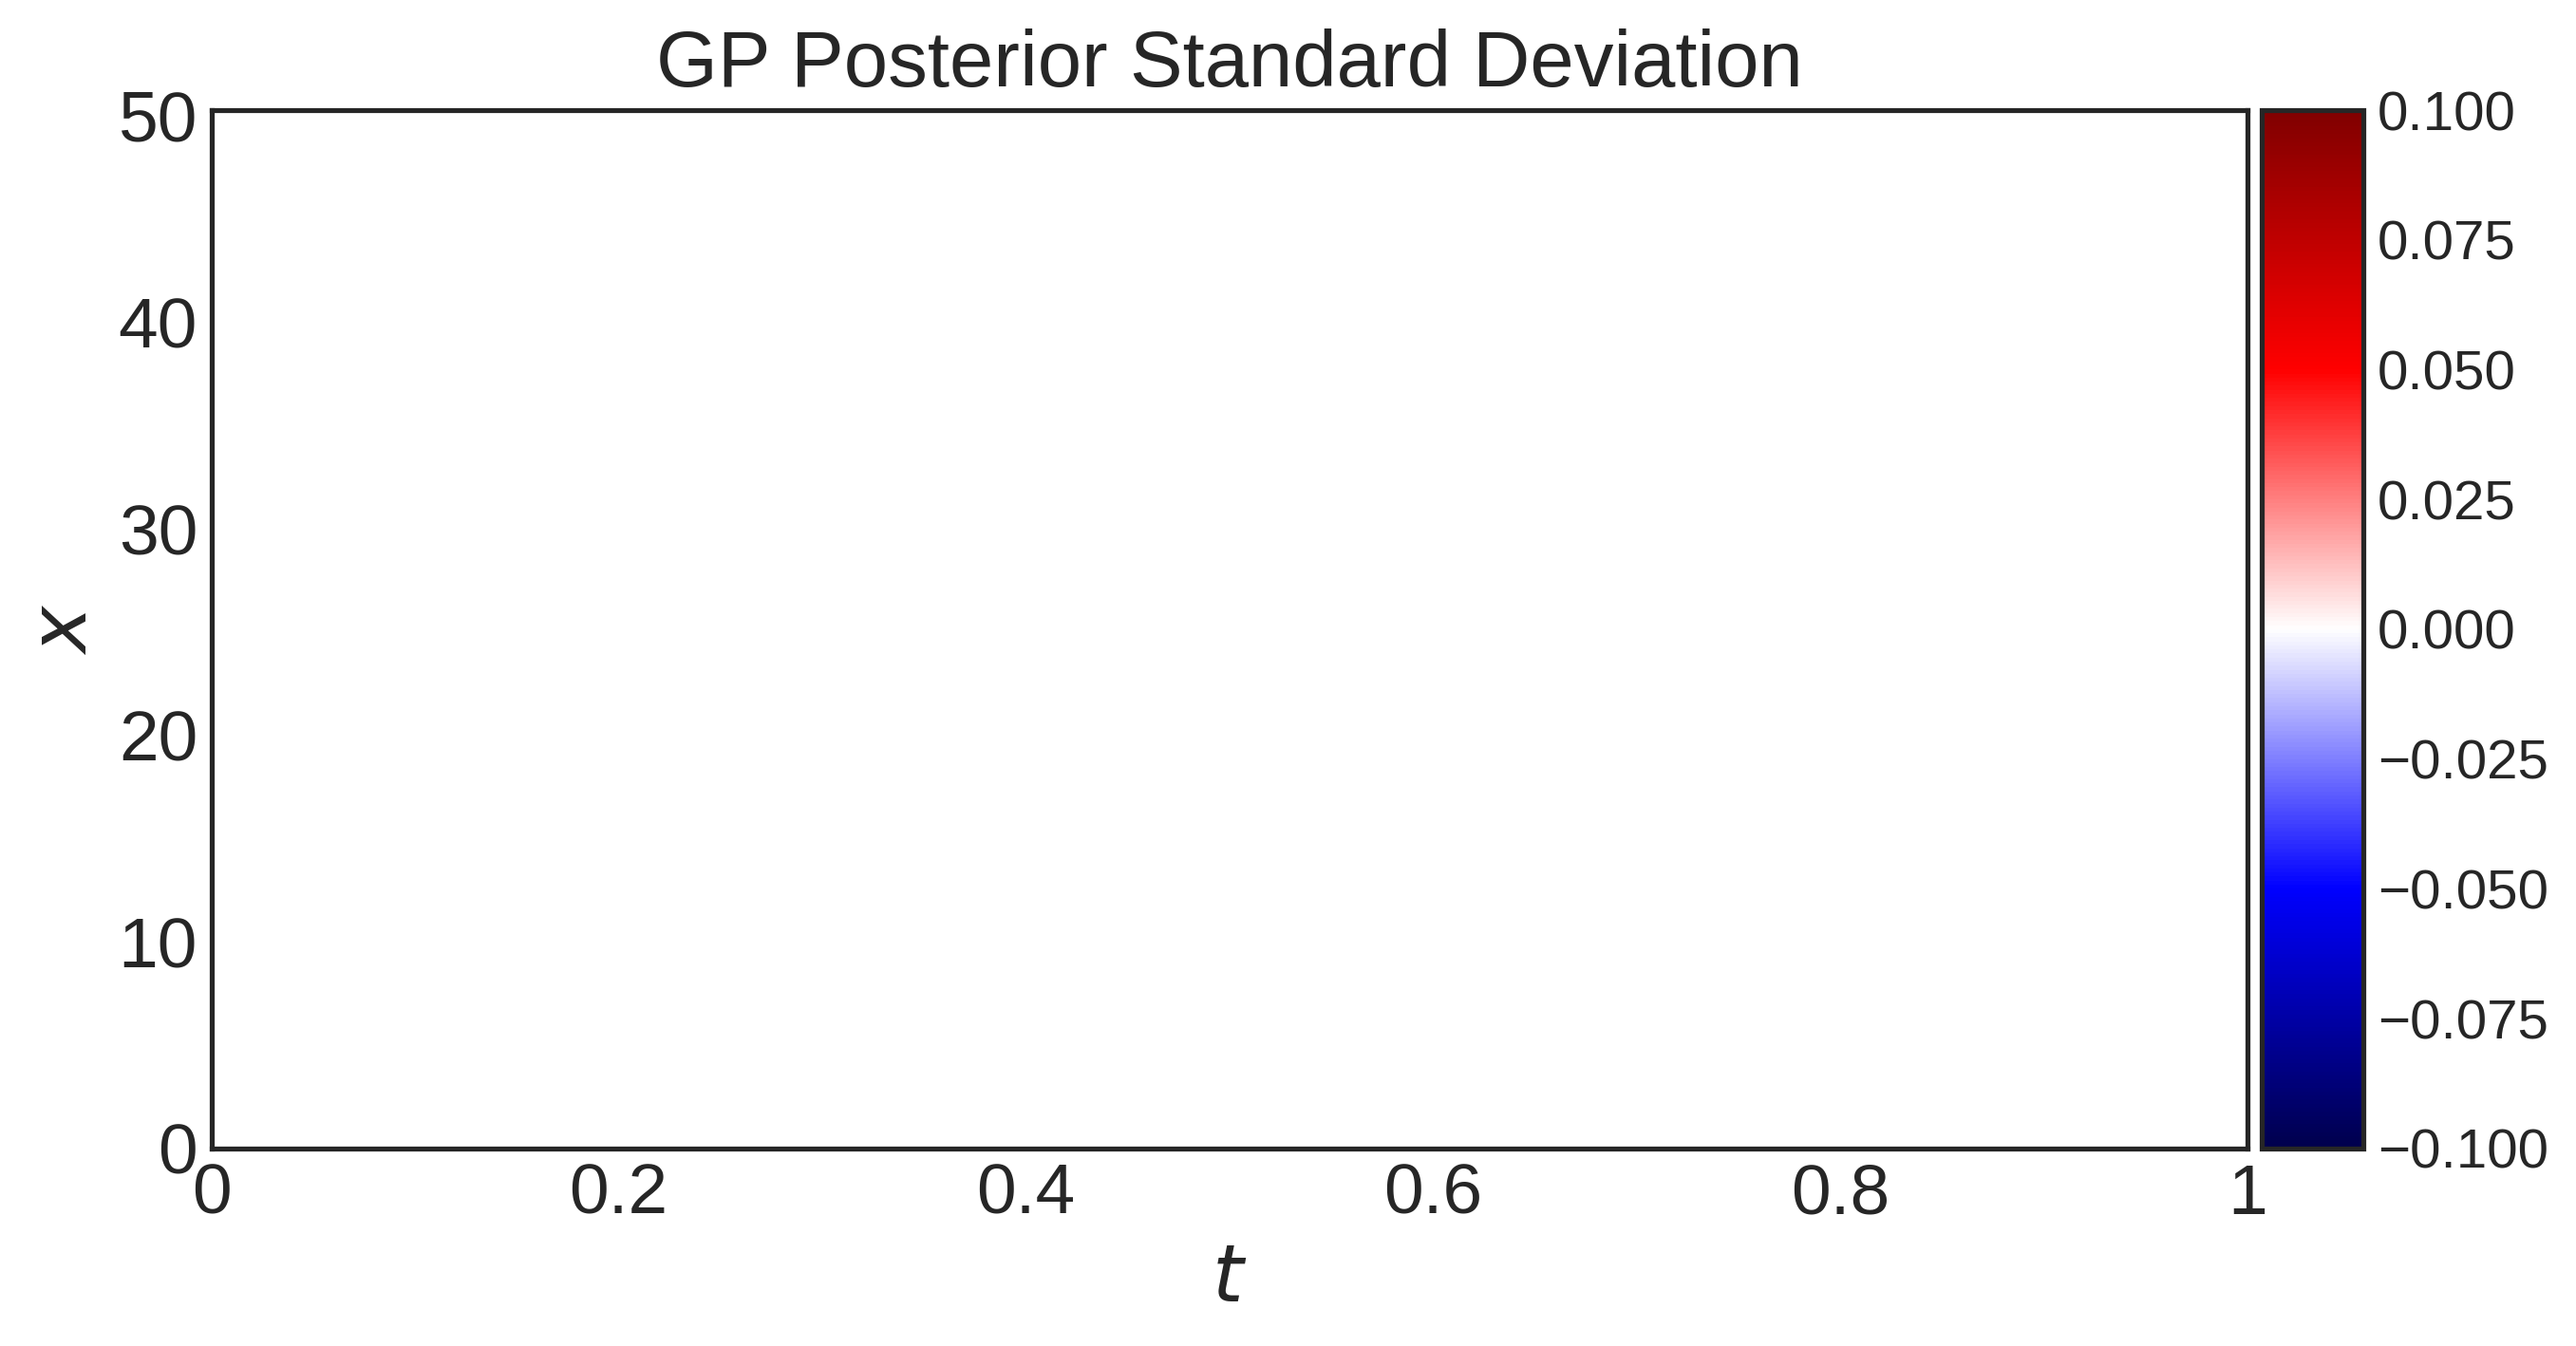

In [ ]:
"""
Display results
"""

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

def figsize(scale, nplots = 1):
    fig_width_pt = 390.0                          # get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                     # convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0          # aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale  # width in inches
    fig_height = nplots*fig_width*golden_mean     # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

# L2 error
#err = np.linalg.norm(u_pm.T-u.T,2)/np.linalg.norm(u.T,2)
#print('L2 error: %.4e' % (err))

# Exact
plt.style.use('seaborn-v0_8-white')
fig = plt.figure(figsize=figsize(2,2),dpi=300)
gs0 = gridspec.GridSpec(1,1)
gs0.update(top=1-0.06,bottom=1-1/3,left=0.2,right=.9,wspace=0.25)
ax = plt.subplot(gs0[0,0])
im=ax.imshow(u,interpolation='nearest',cmap='seismic',
             extent=[ti,tf,xl,xr],origin='lower',aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%",pad=0.05)
cbar=fig.colorbar(im,cax=cax)
cbar.ax.tick_params(labelsize=14)
ax.tick_params(axis='both',which='major',labelsize=18)
ax.set_xticks(np.arange(0,1.01,0.2),labels=['0','0.2','0.4','0.6','0.8','1'])
ax.set_ylabel('$x$',fontsize=20)
ax.set_xlabel('$t$',fontsize=20)
ax.set_title('Exact',fontsize=20)
plt.show()

# Posterior Mean
plt.style.use('seaborn-v0_8-white')
fig = plt.figure(figsize=figsize(2,2),dpi=300)
gs0 = gridspec.GridSpec(1,1)
gs0.update(top=1-0.06,bottom=1-1/3,left=0.2,right=.9,wspace=0.25)
ax = plt.subplot(gs0[0,0])
im=ax.imshow(u_pm,interpolation='nearest',cmap='seismic',
             extent=[ti,tf,xl,xr],origin='lower',aspect='auto')
plt.scatter(Z[:,1],Z[:,0],s=32,marker='.',color='y',alpha=1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right",size="5%",pad=0.05)
cbar=fig.colorbar(im,cax=cax)
cbar.ax.tick_params(labelsize=14)
ax.tick_params(axis='both',which='major',labelsize=18)
ax.set_xticks(np.arange(0,1.01,0.2),labels=['0','0.2','0.4','0.6','0.8','1'])
ax.set_ylabel('$x$',fontsize=20)
ax.set_xlabel('$t$',fontsize=20)
ax.set_title('GP Posterior Mean and Residue Points',fontsize=20)
plt.show()

# |Posterior Mean - Exact|
plt.style.use('seaborn-v0_8-white')
fig = plt.figure(figsize=figsize(2,2),dpi=300)
gs0 = gridspec.GridSpec(1,1)
gs0.update(top=1-0.06,bottom=1-1/3,left=0.2,right=.9,wspace=0.25)
ax = plt.subplot(gs0[0,0])
im=ax.imshow(np.abs(u_pm-u),interpolation='nearest',cmap='seismic',
             extent=[ti,tf,xl,xr],origin='lower',aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar=fig.colorbar(im,cax=cax)
cbar.ax.tick_params(labelsize=14)
ax.tick_params(axis='both',which='major',labelsize=18)
ax.set_xticks(np.arange(0,1.01,0.2),labels=['0','0.2','0.4','0.6','0.8','1'])
ax.set_ylabel('$x$',fontsize=20)
ax.set_xlabel('$t$',fontsize=20)
ax.set_title('Absolute Error',fontsize=20)
plt.show()

# Posterior Standard Deviation
plt.style.use('seaborn-v0_8-white')
fig = plt.figure(figsize=figsize(2,2),dpi=300)
gs0 = gridspec.GridSpec(1,1)
gs0.update(top=1-0.06,bottom=1-1/3,left=0.2,right=.9,wspace=0.25)
ax = plt.subplot(gs0[0,0])
im=ax.imshow(u_sd,interpolation='nearest',cmap='seismic',
             extent=[ti,tf,xl,xr],origin='lower',aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right",size="5%",pad=0.05)
cbar=fig.colorbar(im,cax=cax)
cbar.ax.tick_params(labelsize=14)
ax.tick_params(axis='both',which='major',labelsize=18)
ax.set_xticks(np.arange(0,1.01,0.2),labels=['0','0.2','0.4','0.6','0.8','1'])
ax.set_ylabel('$x$',fontsize=20)
ax.set_xlabel('$t$',fontsize=20)
ax.set_title('GP Posterior Standard Deviation',fontsize=20)
plt.show()